In [97]:
import csv



def load_data(filename):
    max_temp_list = []
    with open(filename, 'r') as f:
        reader = csv.DictReader(f, delimiter=',')
        for item in reader:
            max_temp_list.append(item['MaxTemp'])
    return max_temp_list

max_temp_list = load_data('Summary of Weather.csv')
print(max_temp_list[0:10])

['25.55555556', '28.88888889', '26.11111111', '26.66666667', '26.66666667', '26.66666667', '28.33333333', '26.66666667', '27.22222222', '25.55555556']


In [98]:
len(max_temp_list)

119040

In [99]:
import numpy as np
max_temp_list = max_temp_list[:-6]
max_temp_list = np.array(max_temp_list, dtype=np.float32)
max_temp_list = max_temp_list.reshape(-1, 51)

In [100]:
len(max_temp_list)

2334

In [101]:
max_temp_list = max_temp_list[..., np.newaxis]

In [102]:
max_temp_list.shape

(2334, 51, 1)

In [103]:
n_steps = 50
series = max_temp_list
X_train, y_train = series[:2000, :n_steps], series[:2000, -1]
X_valid, y_valid = series[2000:2200, :n_steps], series[2000:2200, -1]
X_test, y_test = series[2200:, :n_steps], series[2200:, -1]
X_train.shape, y_train.shape

((2000, 50, 1), (2000, 1))

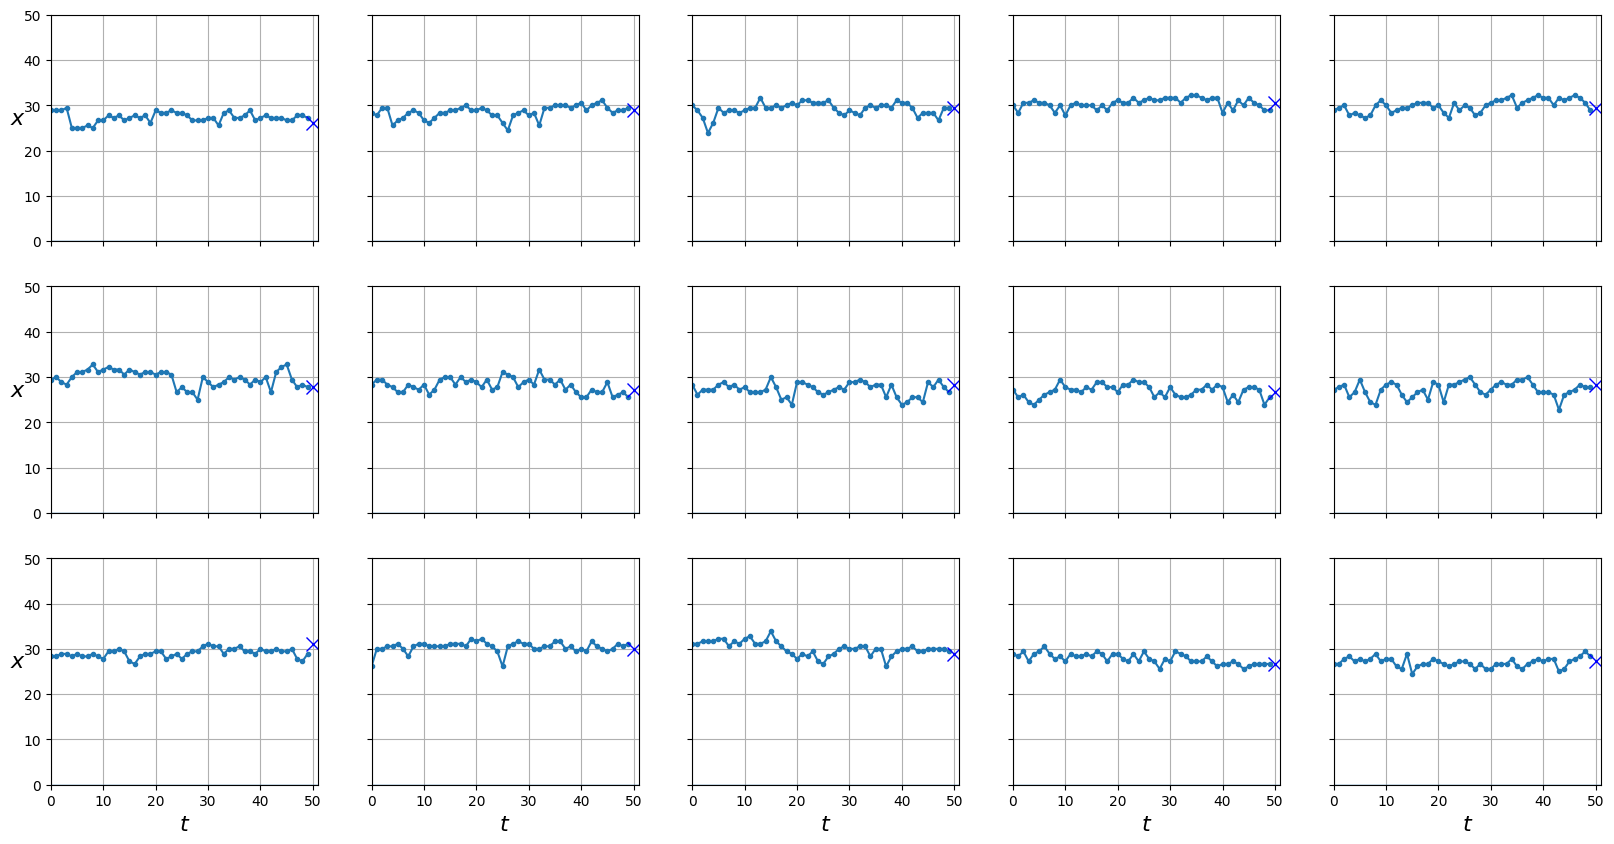

In [104]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c
            plt.plot(series[ix, :], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, len(series[ix, :])+len(y[ix]), 0, 50])
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

plot_series(X_test, y_test)

In [105]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [106]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [107]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=150):
    writer = SummaryWriter()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for i, batch in enumerate(dataloader['train']):
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            if i % 10 == 0:
                writer.add_scalar(f'training loss', loss.item(), epoch * len(dataloader['train']) + i)
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
    
    writer.close()
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [108]:
fit(rnn, dataloader)

loss 6.32362 val_loss 1.87422: 100%|██████████| 150/150 [00:10<00:00, 14.91it/s]   


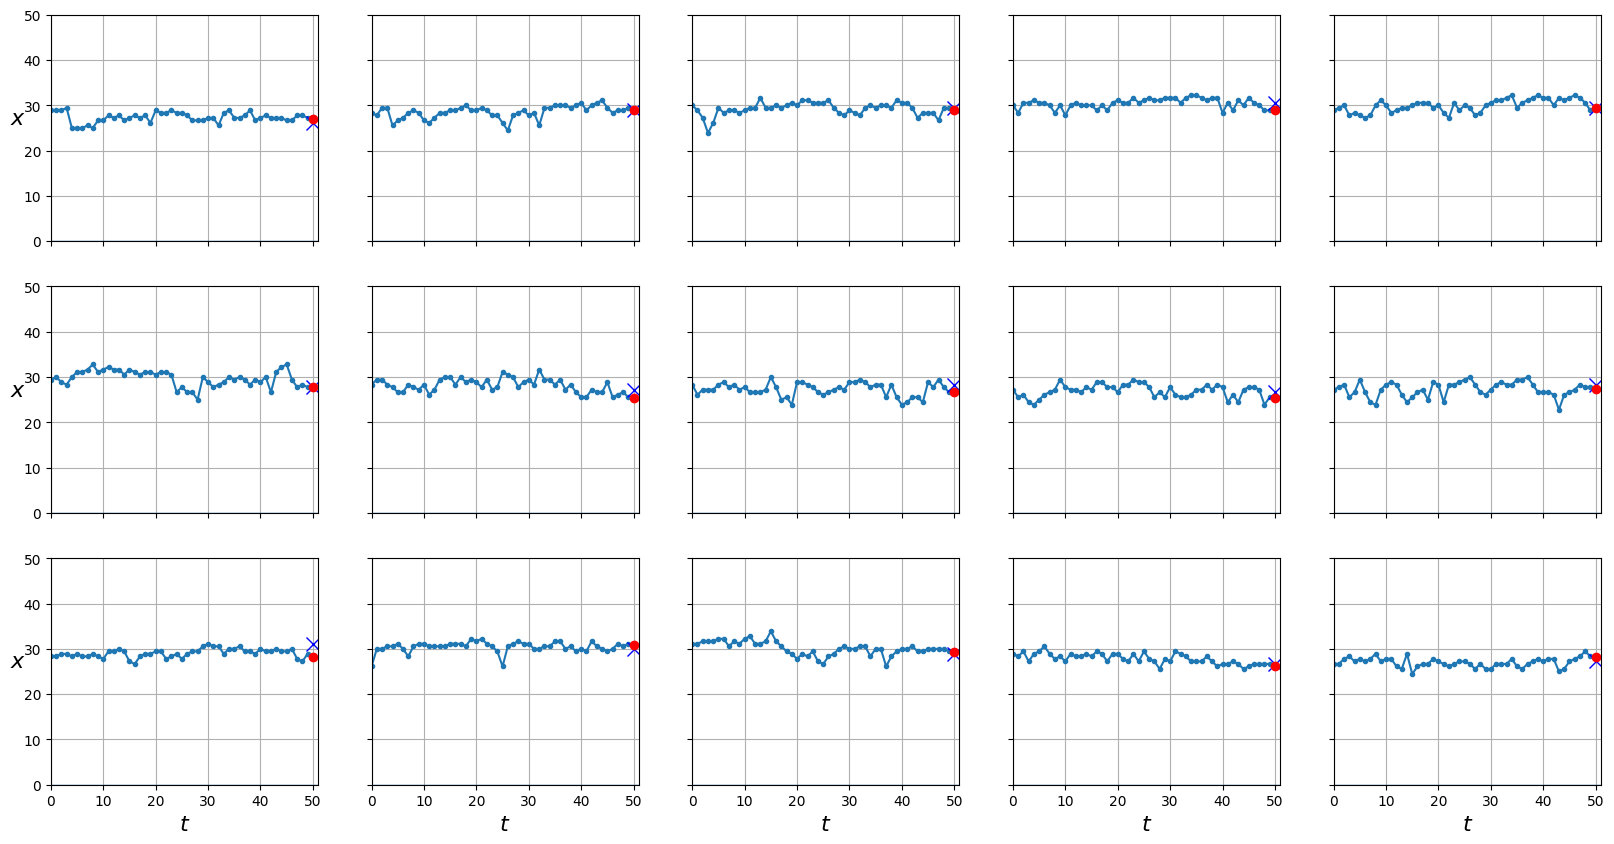

4.56035041809082

In [109]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

In [110]:
# 使用 num_layers参数来控制循环神经网络（RNN）中的隐藏层数量
class DeepRNN(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [111]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 5.48847 val_loss 3.73616: 100%|██████████| 150/150 [00:10<00:00, 14.08it/s]   


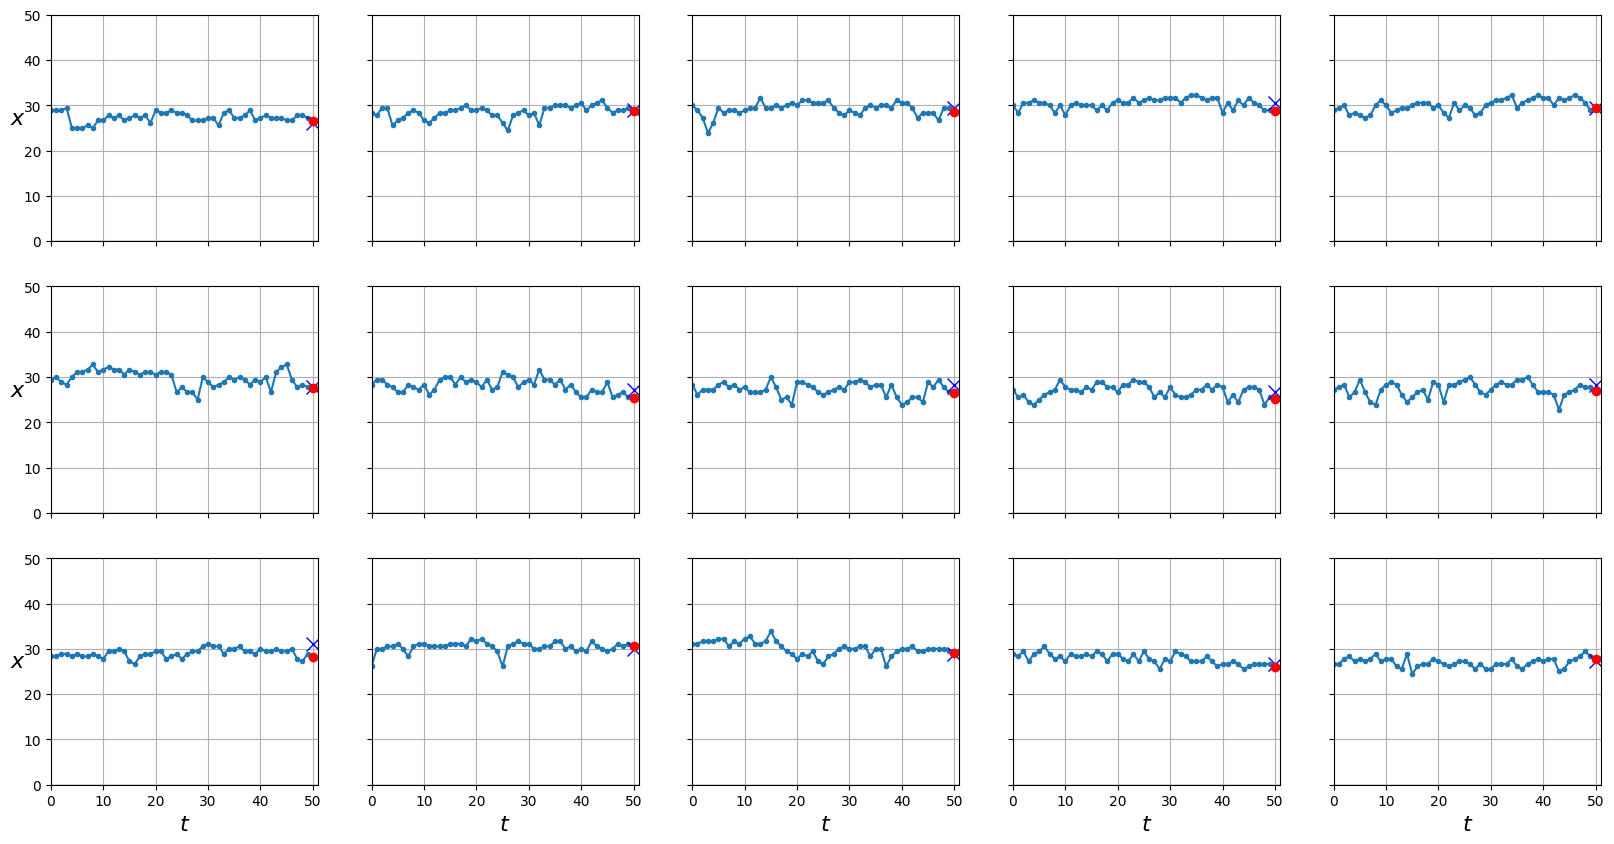

4.459543704986572

In [112]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

In [113]:
max_temp_list = load_data('Summary of Weather.csv')

In [114]:
len(max_temp_list)

119040

In [115]:
119040 % 55

20

In [116]:
max_temp_list = max_temp_list[:-20]
max_temp_list = np.array(max_temp_list, dtype=np.float32)
max_temp_list = max_temp_list.reshape(-1, 55)

In [117]:
max_temp_list = max_temp_list[..., np.newaxis]

In [118]:
max_temp_list.shape

(2164, 55, 1)

In [119]:
n_steps = 50
series = max_temp_list
X_train = series[:1500, :n_steps]
X_valid = series[1500:1700, :n_steps]
X_test = series[1700:, :n_steps]
Y = np.empty((2164, n_steps, 5), dtype=np.float32)
for step_ahead in range(1, 5 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:1500]
Y_valid = Y[1500:1700]
Y_test = Y[1700:]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [120]:

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [121]:
Y_train.shape

(1500, 50, 5)

In [122]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=5):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [123]:
def fit(model, dataloader, epochs=100):
    writer = SummaryWriter()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for i, batch in enumerate(dataloader['train']):
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())

            if i % 10 == 0:
                writer.add_scalar(f'training loss', loss.item(), epoch * len(dataloader['train']) + i)
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")
    writer.close()

In [124]:
rnn = DeepRNN()
fit(rnn, dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

loss 16.07287 loss_last_step 17.07388 val_loss 23.84223 val_loss_last_step 23.22220: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]   


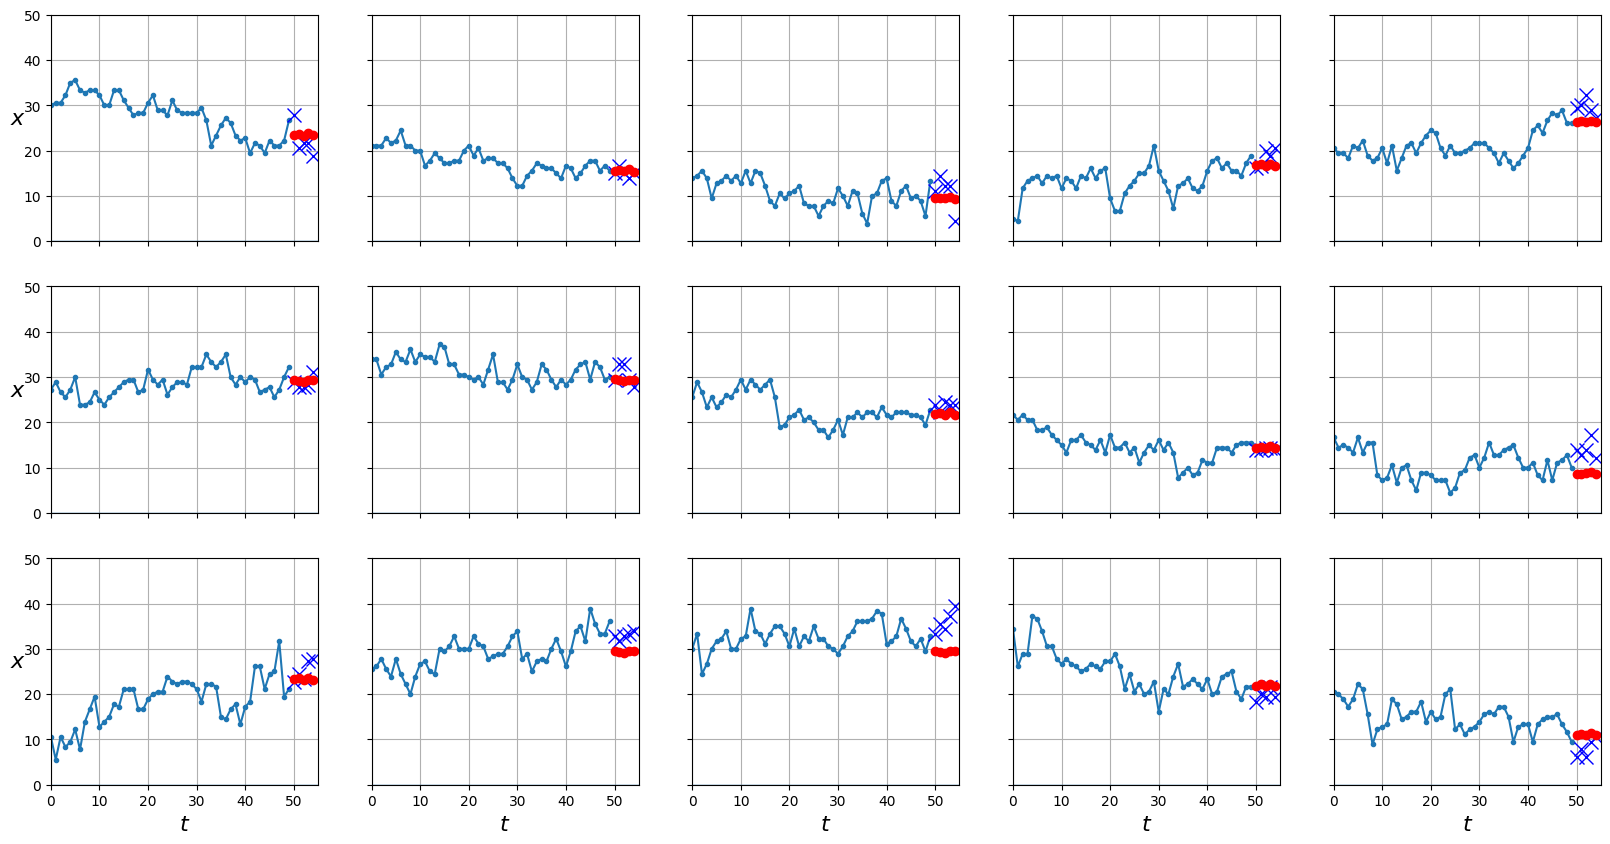

7.688106536865234

In [125]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())